## 第十周: 字詞分類

**Author:** 黃天原<br>
**Date created:** 2021/10/01<br>
**Last modified:** 2021/11/17<br>
本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用 logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「英文」的文件分類，使用Jane austen的pride and prejudice與H. G. Wells的the war of the worlds做示範。

In [13]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
#匯入資料
tp = pd.read_csv('./raw_data/en_tp_clean.csv')
war = pd.read_csv('./raw_data/war_clean.csv')

進行一些前處裡

In [3]:
tp.drop(columns="chapter", inplace=True)
tp['title'] = 'pride and prejudice'
war['title'] = 'The War of the Worlds'
books = pd.concat([tp,war],axis=0)

In [4]:
books.dropna(inplace=True)

In [5]:
books

,sentence,title
0,TPRIDE PREJUDICE,pride and prejudice
1,It is a truth universally acknowledged that a ...,pride and prejudice
2,However little known the feelings or views of ...,pride and prejudice
3,My dear Mr_Bennet said his lady to him one day...,pride and prejudice
4,Mr_Bennet replied that he had not,pride and prejudice
...,...,...
3218,general information project gutenbergtm electr...,The War of the Worlds
3219,forty years produced distributed project guten...,The War of the Worlds
3220,project gutenbergtm ebooks often created sever...,The War of the Worlds
3221,thus necessarily keep ebooks compliance partic...,The War of the Worlds


In [6]:
# 書名章節數量
books['title'].value_counts()

pride and prejudice      5793
The War of the Worlds    3176
Name: title, dtype: int64

## 2 分類模型的訓練流程

### 2.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 raw_data 隨機切成 7:3，設置 `random_state` 讓每次切分的結果一致。y_train和y_test分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [7]:
data = books.copy()
X = data["sentence"]
y = data["title"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

X_train.head()

2358    When Lady Catherine and her daughter had playe...
3704    Her teeth are tolerable but not out of the com...
1073    would seem giants spent earlier part afternoon...
2076    My aunt she continued is going tomorrow into t...
662     little depressed first contagion wifes fears s...
Name: sentence, dtype: object

In [8]:
y_train.head()

2358      pride and prejudice
3704      pride and prejudice
1073    The War of the Worlds
2076      pride and prejudice
662     The War of the Worlds
Name: title, dtype: object

In [9]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['title'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
pride and prejudice      64.58914
The War of the Worlds    35.41086
Name: title, dtype: float64

train percentage :
pride and prejudice      65.148136
The War of the Worlds    34.851864
Name: title, dtype: float64

test percentage :
pride and prejudice      63.285024
The War of the Worlds    36.714976
Name: title, dtype: float64


### 2.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)

In [10]:
# vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_test = vectorizer.transform(X_test)

# classifier
clf = LogisticRegression()
clf.fit(vec_train, y_train)

y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

In [11]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

                       precision    recall  f1-score   support

The War of the Worlds       0.90      0.76      0.82       988
  pride and prejudice       0.87      0.95      0.91      1703

             accuracy                           0.88      2691
            macro avg       0.89      0.85      0.87      2691
         weighted avg       0.88      0.88      0.88      2691



(array([0.5, 1.5]),
 [Text(0, 0.5, 'The War of the Worlds'), Text(0, 1.5, 'pride and prejudice')])

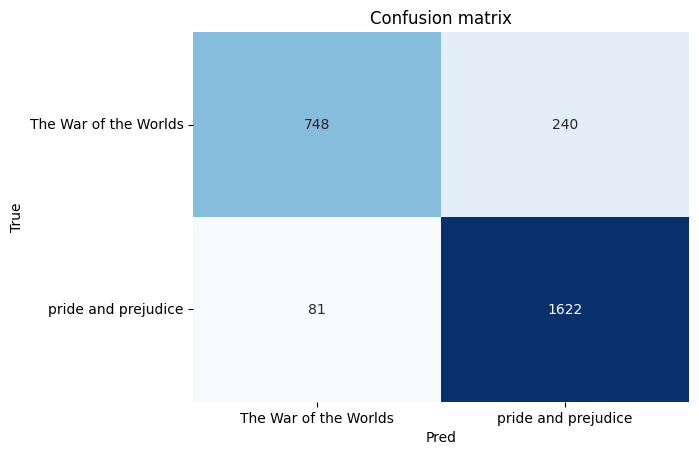

In [12]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [33]:
enc = OneHotEncoder(sparse=False)
enc.fit(y_train.values.reshape(-1, 1))
y_onehot_test = enc.transform(y_test.values.reshape(-1, 1))
y_onehot_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [35]:
y_test.head()

587       pride and prejudice
1303    The War of the Worlds
5471      pride and prejudice
4224      pride and prejudice
271       pride and prejudice
Name: title, dtype: object

In [70]:
clf.classes_

array(['The War of the Worlds', 'pride and prejudice'], dtype=object)

In [27]:
enc.categories_

[array(['The War of the Worlds', 'pride and prejudice'], dtype=object)]

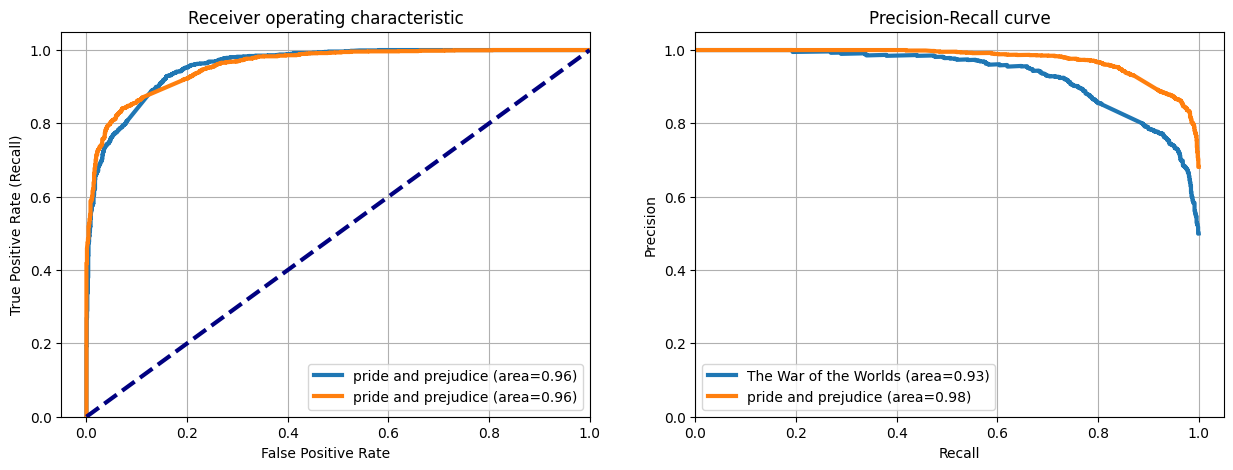

In [36]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[1], auc(fpr, tpr))
    )
    
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()

### tfidf

In [73]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

                       precision    recall  f1-score   support

The War of the Worlds       0.92      0.74      0.82       988
  pride and prejudice       0.86      0.96      0.91      1703

             accuracy                           0.88      2691
            macro avg       0.89      0.85      0.86      2691
         weighted avg       0.88      0.88      0.88      2691



### cross validation

                       precision    recall  f1-score   support

The War of the Worlds       0.89      0.76      0.82      2188
  pride and prejudice       0.88      0.95      0.91      4090

             accuracy                           0.88      6278
            macro avg       0.89      0.85      0.87      6278
         weighted avg       0.88      0.88      0.88      6278



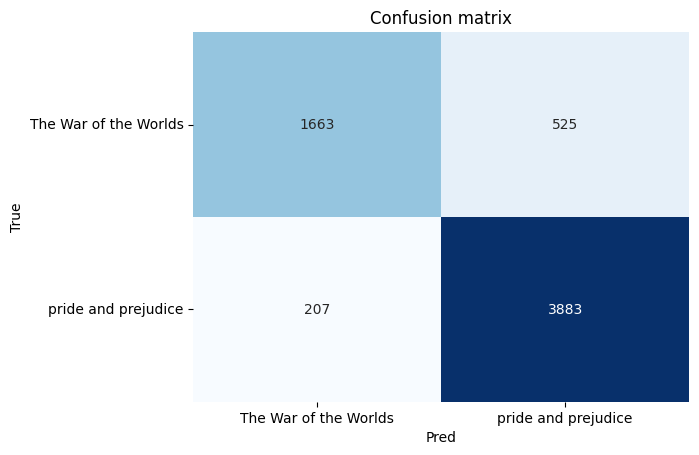

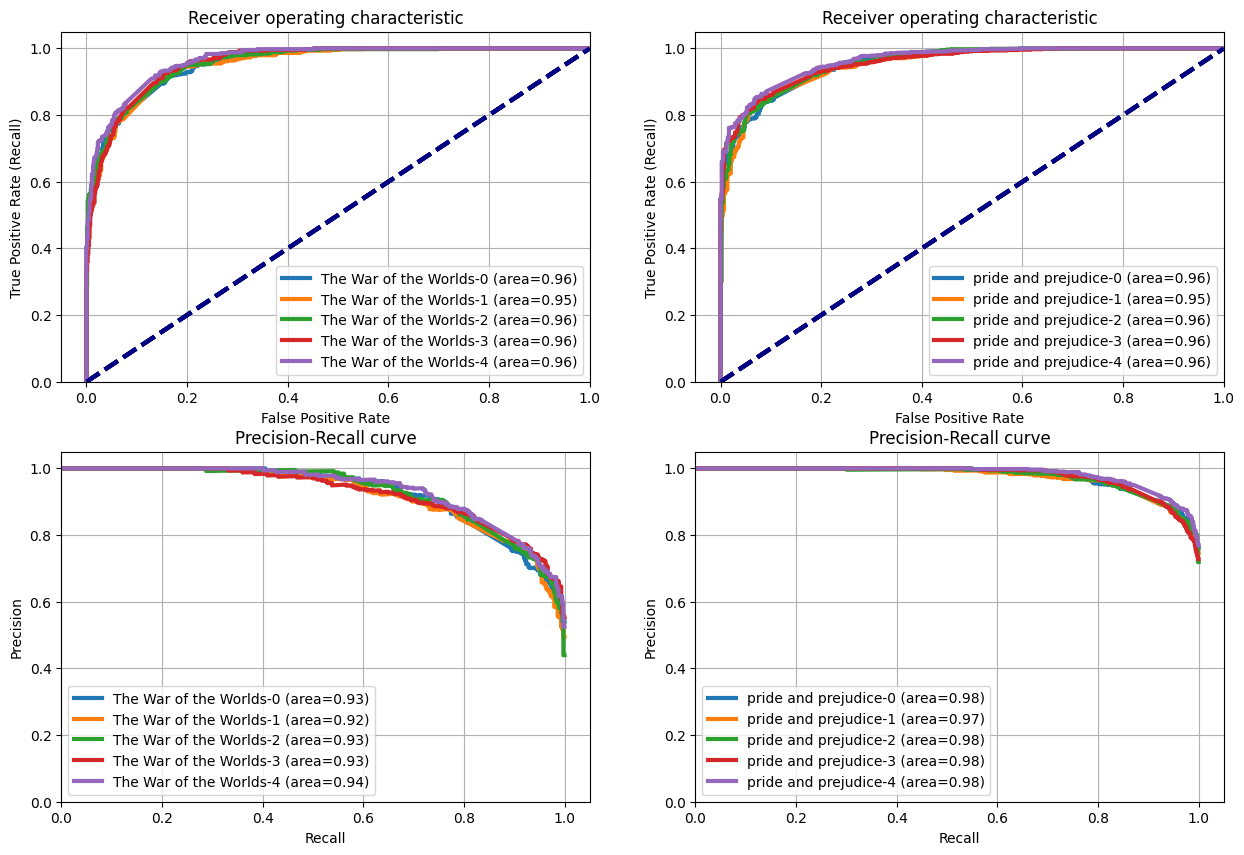

In [40]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")

    # one-hot encoding
    enc = OneHotEncoder(sparse=False)
    enc.fit(y.values.reshape(-1, 1))
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])
        y_onehot_test = enc.transform(y_test.values.reshape(-1, 1))
            
        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
            ax[0,i].plot(
                fpr,
                tpr,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
            )
            ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
            ax[0,i].set(
                xlim=[-0.05, 1.0],
                ylim=[0.0, 1.05],
                xlabel="False Positive Rate",
                ylabel="True Positive Rate (Recall)",
                title="Receiver operating characteristic",
            )
            ax[0,i].legend(loc="best")
            ax[0,i].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = precision_recall_curve(
                y_onehot_test[:, i], y_pred_proba[:, i]
            )
            ax[1,i].plot(
                recall,
                precision,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
            )
            ax[1,i].set(
                xlim=[0.0, 1.05],
                ylim=[0.0, 1.05],
                xlabel="Recall",
                ylabel="Precision",
                title="Precision-Recall curve",
            )
            ax[1,i].legend(loc="best")
            ax[1,i].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

vectorizer = CountVectorizer(max_features=1000, stop_words="english")
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

## 3 比較不同模型的效果

now training: clf_logistic
                       precision    recall  f1-score   support

The War of the Worlds       0.89      0.76      0.82      2188
  pride and prejudice       0.88      0.95      0.91      4090

             accuracy                           0.88      6278
            macro avg       0.89      0.85      0.87      6278
         weighted avg       0.88      0.88      0.88      6278



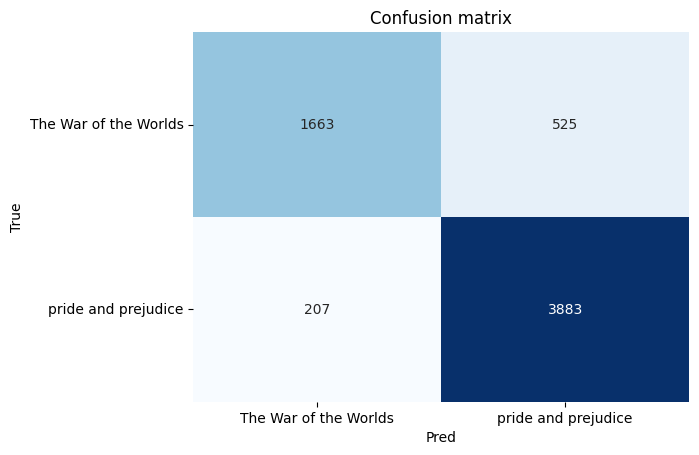

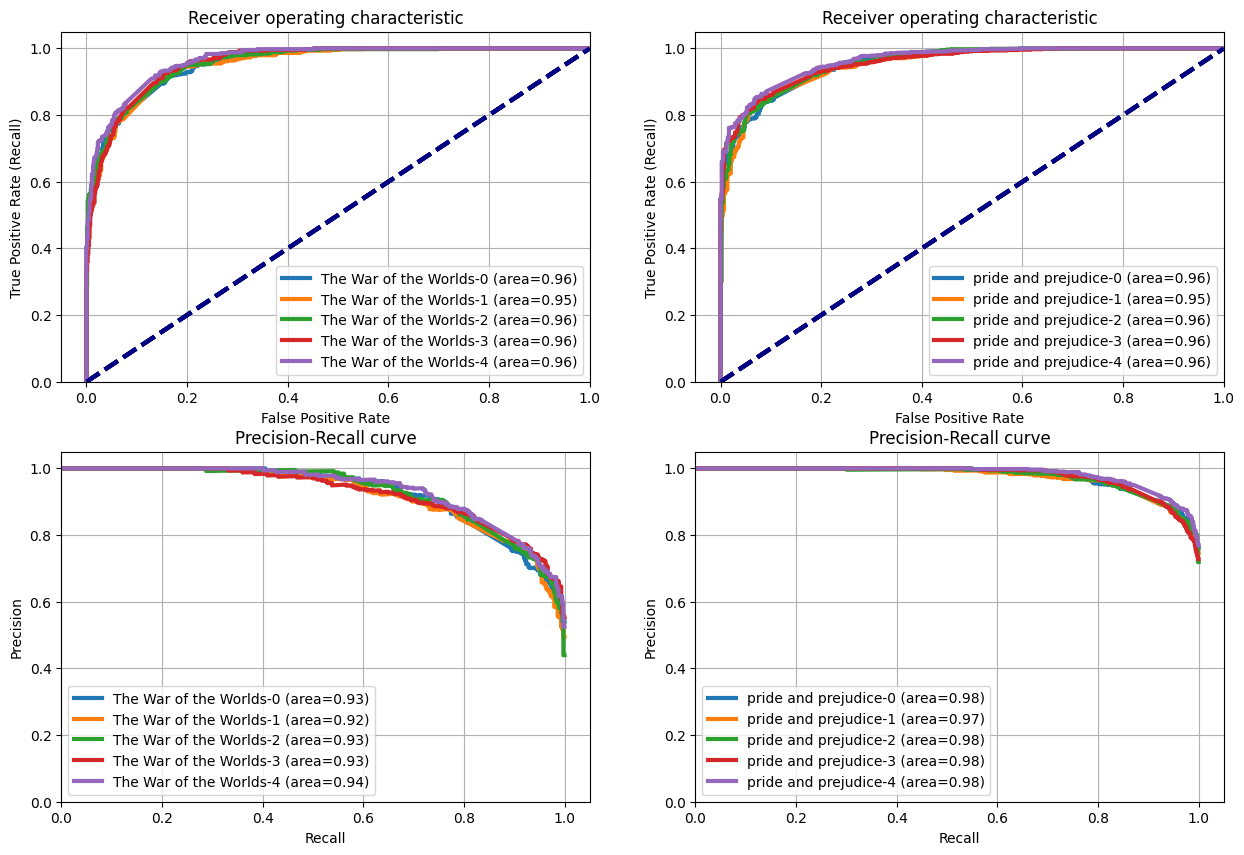

now training: clf_dtree
                       precision    recall  f1-score   support

The War of the Worlds       0.73      0.77      0.75      2188
  pride and prejudice       0.87      0.85      0.86      4090

             accuracy                           0.82      6278
            macro avg       0.80      0.81      0.80      6278
         weighted avg       0.82      0.82      0.82      6278



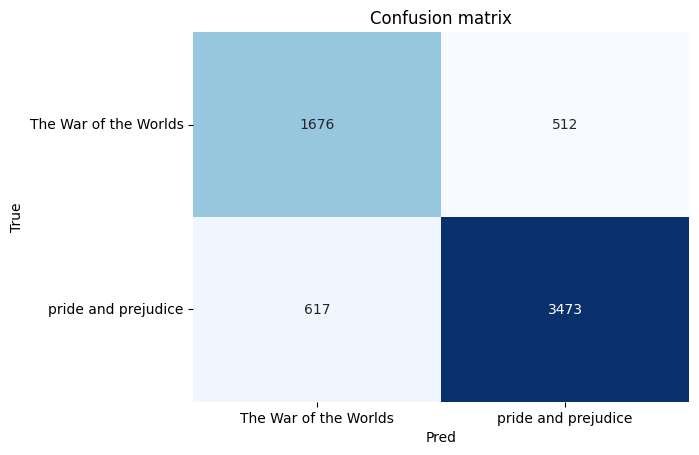

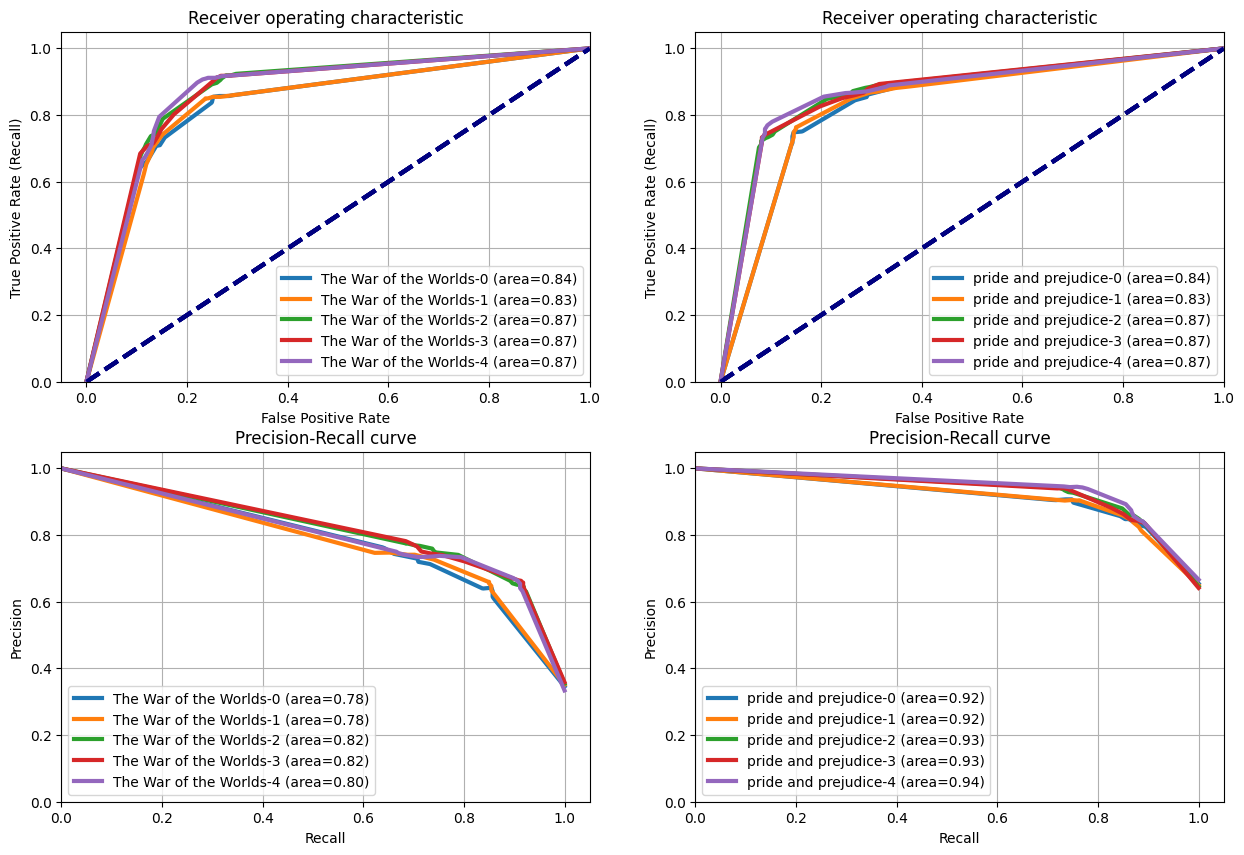

In [41]:
# 準備訓練資料
X = data["sentence"]
y = data["title"]
# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
# 定義 vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [77]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")

best model: clf_logistic


In [78]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

                       precision    recall  f1-score   support

The War of the Worlds       0.90      0.76      0.82       988
  pride and prejudice       0.87      0.95      0.91      1703

             accuracy                           0.88      2691
            macro avg       0.89      0.85      0.87      2691
         weighted avg       0.88      0.88      0.88      2691



## 4 分析可解釋模型的結果
### 4.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

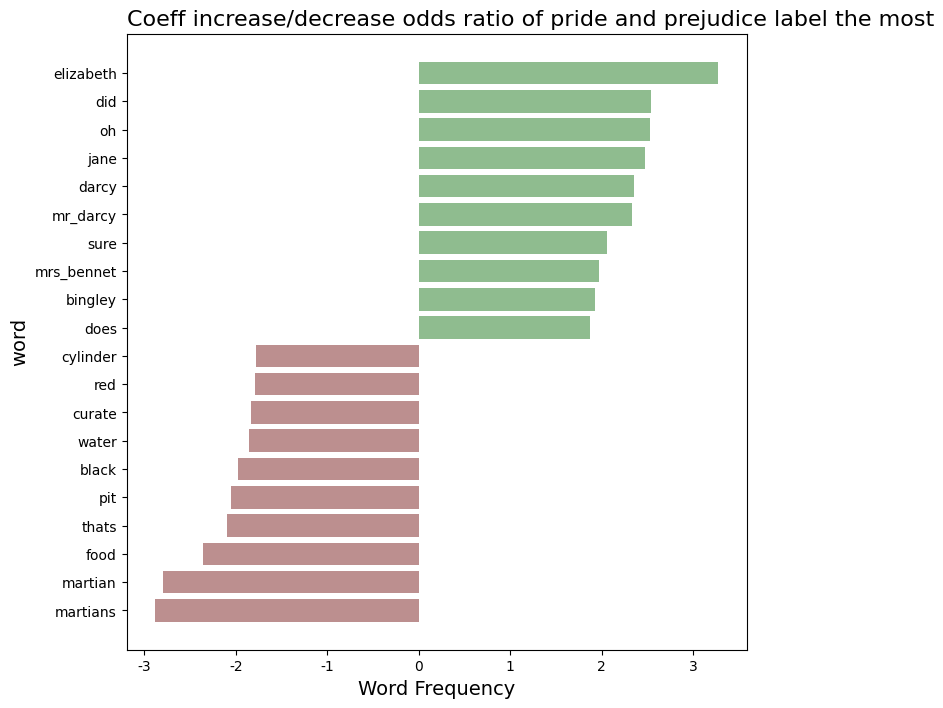

In [80]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_[[1]], index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of " + label + " label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

# plot logistic model
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names(), top_n=10)

結果顯示，人名的 feature 影響力滿大的，Elizabeth 是傲慢與偏見的主角，所以最高；martian（火星人）完全是 The War of the Worlds 這本小說才有的角色（？），所以則是負向影響最大。

## 5 結果

1. 相較於中文分類，英文小說的分類預測反而差很多。
2. 在模型比較上，決策樹的表現也明顯低於 logistic。tree-base 模型為何在此文集上表現較差呢？

## 附錄

附錄附上一些 code，是用 `GridSearchCV` 去挑出最佳參數。不過就算找一個最佳參數組合，決策樹的效果還是不好。

In [43]:
dtree = DecisionTreeClassifier()
dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [64]:
dtree = DecisionTreeClassifier()
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")

scores = "f1_macro"

tuned_parameters = {
    "max_depth": [1, 5, 10, 100, 1000, None], 
    "min_samples_split": [2, 10, 100 ,1000], 
    "min_samples_leaf": [1, 10, 100, 1000],
    "min_weight_fraction_leaf": [0.0, 0.01, 0.1, 0.5],
}

grid_search = GridSearchCV(
    dtree, tuned_parameters, scoring=scores, n_jobs=16, verbose=1
)
grid_search.fit(tfidf_vectorizer.fit_transform(X_train).toarray(), y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=16,
             param_grid={'max_depth': [1, 5, 10, 100, 1000, None],
                         'min_samples_leaf': [1, 10, 100, 1000],
                         'min_samples_split': [2, 10, 100, 1000],
                         'min_weight_fraction_leaf': [0.0, 0.01, 0.1, 0.5]},
             scoring='f1_macro', verbose=1)

In [65]:
grid_search.best_estimator_

DecisionTreeClassifier(min_samples_split=100)

In [69]:
pd.DataFrame(grid_search.cv_results_).to_csv("results.csv")

In [70]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_min_weight_fraction_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
328,4.117877,0.750859,0.009085,0.000258,None,1,100,0.0,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.802762,0.809466,0.818658,0.806169,0.822250,0.811861,0.007417,1
332,3.536298,0.399101,0.008906,0.000143,None,1,1000,0.0,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.803055,0.805723,0.816725,0.809857,0.821514,0.811375,0.006854,2
268,4.016523,0.563755,0.008924,0.000279,1000,1,1000,0.0,"{'max_depth': 1000, 'min_samples_leaf': 1, 'mi...",0.801827,0.807837,0.811483,0.805765,0.823448,0.810072,0.007382,3
264,3.586515,0.327199,0.009394,0.000892,1000,1,100,0.0,"{'max_depth': 1000, 'min_samples_leaf': 1, 'mi...",0.812251,0.807275,0.812067,0.797016,0.820919,0.809906,0.007804,4
320,4.312320,1.044194,0.010130,0.002681,None,1,2,0.0,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.803401,0.798718,0.814585,0.813727,0.814506,0.808987,0.006647,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.083051,0.008649,0.012952,0.001780,5,1000,1000,0.5,"{'max_depth': 5, 'min_samples_leaf': 1000, 'mi...",0.394407,0.394407,0.394407,0.394597,0.394597,0.394483,0.000093,121
126,0.094004,0.010750,0.012990,0.001710,5,1000,1000,0.1,"{'max_depth': 5, 'min_samples_leaf': 1000, 'mi...",0.394407,0.394407,0.394407,0.394597,0.394597,0.394483,0.000093,121
125,0.158424,0.028519,0.013490,0.002299,5,1000,1000,0.01,"{'max_depth': 5, 'min_samples_leaf': 1000, 'mi...",0.394407,0.394407,0.394407,0.394597,0.394597,0.394483,0.000093,121
223,0.076990,0.021366,0.009514,0.002615,100,10,1000,0.5,"{'max_depth': 100, 'min_samples_leaf': 10, 'mi...",0.394407,0.394407,0.394407,0.394597,0.394597,0.394483,0.000093,121
